# Interpolation in geospatial datasets using Gaussian Process Regression

### Why spatial interpolation?

Spatial interpolation is an important task for both raster and vector spatial data, to:
- Resample gridded data to another grid
- Increase the resolution of point-based data
- Impute missing spatial data

### Why Gaussian Process Regression?

GPR is commonly used for spatial interpolation tasks (see [Kriging](https://en.wikipedia.org/wiki/Kriging)). [`scikit-learn`'s implementation](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-regression-gpr) assumes Gaussian likelihood of the data. Here we show how we use MCMC sampling to solve GPR with a non-Gaussian likelihood for count data.

### Contents

1. Gaussian Process Regression with MCMC with the preconditioned Crank-Nicholson proposal
2. Gaussian Process Regression with MCMC with traditional Metropolis-Hastings
3. GPR with the Laplace approximation
4. GPR in closed-form assuming Gaussian likelihood 

In [1]:
from gpr_mcmc import GaussianProcessMCMCRegressor as GPMR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(42)

The data here used is bike thefts from Lewisham, London:

In [2]:
df = pd.read_csv('sample_data/data.csv')

y = df["bicycle.theft"].to_numpy()
X = df[['xi', 'yi']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=42)

### GPR with MCMC (PCN)

In [3]:
gpmr = GPMR(ell=0.2, log_likelihood='poisson', random_state=rng)

In [4]:
gpmr.fit(X_train, y_train)

In [5]:
y_pred = gpmr.predict(X_test, return_train_preds=True)

100%|██████████| 10000/10000 [00:00<00:00, 10696.10it/s]


In [6]:
gpmr.score(X_test, y_test, method="mae")

100%|██████████| 10000/10000 [00:00<00:00, 11279.18it/s]


1.5166518280476882

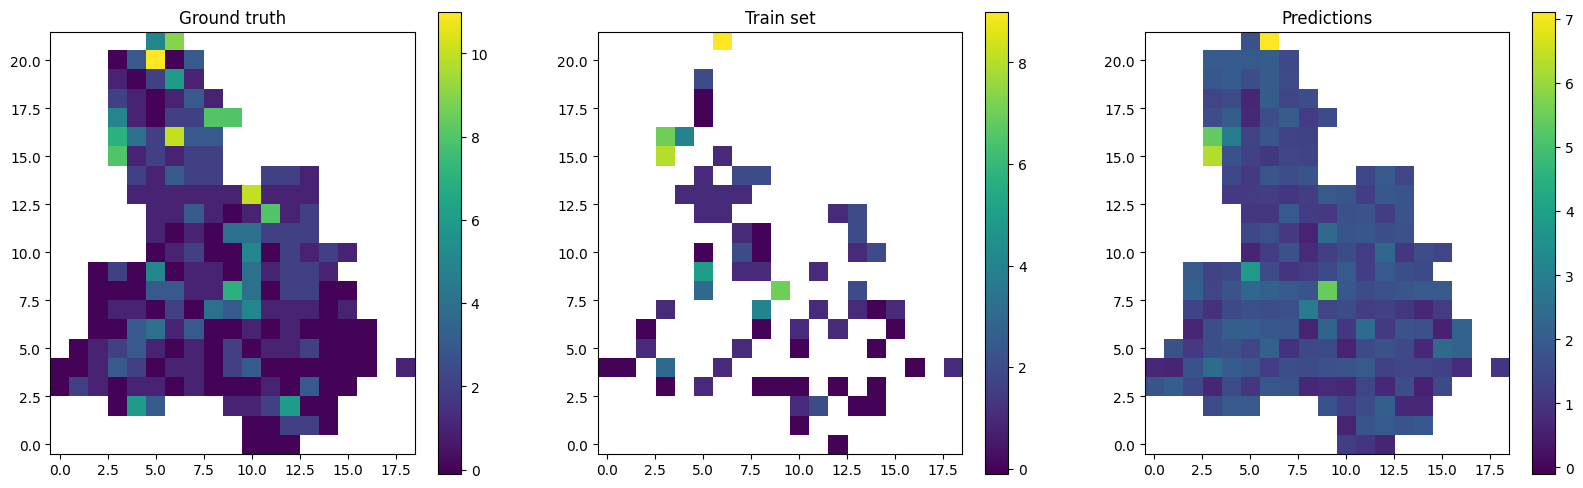

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

GPMR.plot(X, y, ax=ax1, title="Ground truth", pos_only=True)
GPMR.plot(X_train, y_train, ax=ax2, title="Train set", pos_only=True)
GPMR.plot(np.vstack([X_test, X_train]), y_pred, ax=ax3, title="Predictions", pos_only=True) 

### GPR with MCMC (GRW)

In [10]:
gpmr = GPMR(ell=0.2, log_likelihood='poisson', mcmc_method='grw', random_state=rng)

In [11]:
gpmr.fit(X_train, y_train)

In [12]:
y_pred = gpmr.predict(X_test, return_train_preds=True)

100%|██████████| 10000/10000 [00:05<00:00, 1668.18it/s]


In [13]:
gpmr.score(X_test, y_test, method="mae")

100%|██████████| 10000/10000 [00:05<00:00, 1695.05it/s]


1.586216214295675

### GPR with Laplace approximation

### GPR with exact Gaussian likelihood

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error

In [15]:
gpr = GaussianProcessRegressor(kernel=gpmr.kernel_, optimizer=None, random_state=42)

In [16]:
gpr.fit(X_train, y_train);

In [17]:
y_pred = gpr.predict(np.vstack([X_test, X_train]))

In [18]:
mean_absolute_error(y_test, gpr.predict(X_test))

1.7553935922349908

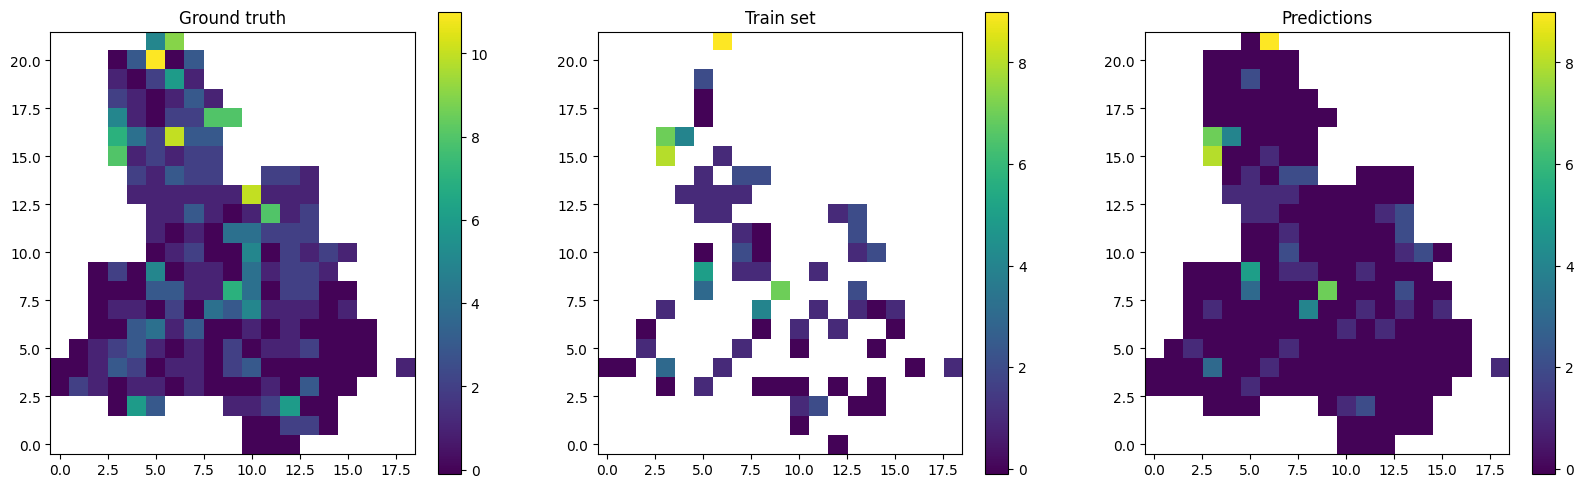

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

GPMR.plot(X, y, ax=ax1, title="Ground truth", pos_only=True)
GPMR.plot(X_train, y_train, ax=ax2, title="Train set", pos_only=True)
GPMR.plot(np.vstack([X_test, X_train]), y_pred, ax=ax3, title="Predictions", pos_only=True) 